**Chapter 6 – Decision Trees**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/HOGENT-ML/course/blob/main/060-decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.7 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥1.01.

In [1]:
# Python ≥3.7 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥1.01 is required
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Training and Visualizing a Decision Tree

- Like SVMs, Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. 
- Powerful algorithms, capable of fitting complex datasets.
- Fundamental components of Random Forests (see next chapter).

Let’s build one and take a look at how it makes predictions.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualize the trained Decision Tree by first using the `export_graphviz()` method to output a graph definition file called iris_tree.dot.  

You first have to:
- pip install graphviz (or py -m pip install graphviz)
- install the dot executable from http://www.graphviz.org/download/ (indicate to add the executables to the OS PATH)

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

IMAGES_PATH = "."

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Now you can execute  

  `dot -Tpng iris_tree.dot -o iris_tree.png`  
  
(if it still doesn't find the path, try this: "C:\Program Files\Graphviz\bin\dot" -Tpng iris_tree.dot -o iris_tree.png)
from the command prompt from the right folder 

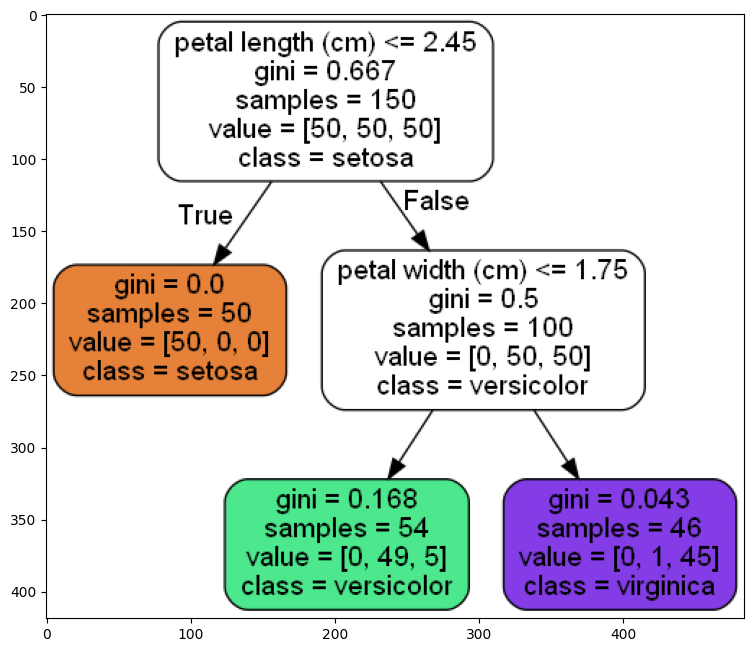

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(9,9))
img = mpimg.imread('img/iris_tree.png')
imgplot = plt.imshow(img)
plt.show()

## Making Predictions

We can now use the tree represented above to make predictions if you find an iris an want to classify it. 
- start at the _root node_ (depth 0, at the top): 
- this node asks whether the flower’s petal length is smaller than or equal to 2.45 cm.
    - if it is you move down to the root’s left child node (depth 1, left).
    - this is a leaf node (it does not have any children), so it does not ask any more questions.
    - the decision tree predicts that your flower is a _Iris setosa_
- suppose you find another flower, and this time the petal length is greater than 2.45 cm
    - You move down to the root’s right child node (depth 1, right), which is not a leaf node
    - This node asks another question: is the petal width smaller than 1.75 cm?
    - If it is, then your flower is most likely an _Iris versicolor_ (depth 2, left). 
    - If not, it is likely an _Iris virginica_ (depth 2, right).

- `samples` = how many training instances node applies to
- `value` = how many training instances of each class node applies to
- `gini` = _impurity_ of node:


$$
G_i = 1 - \sum_{k=1}^np_{i,k}^2
$$
where:
- $p_{i,k}$ = ratio of class $k$ instances among the training instances in the $i^{th}$ node. 

---
**NOTES** 

- One of the many qualities of Decision Trees is that they require very little data preparation. In fact, they
don’t require feature scaling or centering at all.
- Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers).  
However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.
---
The figure below show this decision trees boundaries. 
![](img/decision_tree_decision_boundaries_plot.png)





- Since the `max_depth` hyperparameter was set to 2 their are still impurities in the lefthand area. 
- If you set `max_depth` to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).

---
### MODEL INTERPRETATION: WHITE BOX VERSUS BLACK BOX

- Decision Trees are intuitive, and their decisions are easy to interpret. 
- Such models are often called `white box` models. 
- In contrast, as we will see, Random Forests or neural networks are generally considered black `box models`.  
    - They make great predictions, and you can easily check the calculations that they performed to make these predictions.
    - Nevertheless, it is usually hard to explain in simple terms why the predictions were made. 
    - For example, if a neural network says that a particular person appears on a picture, it is hard to know what contributed to this prediction: did the model recognize that person’s eyes? Their mouth? Their nose? Their shoes? Or even the couch that they were sitting on? 
- Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if need be (e.g., for flower classification).
---

# Estimating Class Probabilities

- To estimate the probability that an instance belongs to a particular class $k$. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node.
- Suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. 
    - The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 
        - 0% for Iris setosa (0/54)
        - 90.7% for Iris versicolor (49/54)
        - 9.3% for Iris virginica (5/54). 
    - If you ask it to predict the class, it should output Iris versicolor (class 1) because it has the highest probability.
    - Notice that the estimated probabilities would be identical anywhere else in the bottom-right rectangle.

In [11]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [12]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART training algorithm
- Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). 
- The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t$ (e.g., “petal length ≤ 2.45 cm”).
- It chooses $k$ and $t$ by searching for the pair $(k, t )$ that produces the purest subsets (weighted by their size). 
- The equation gives the cost function that the algorithm tries to minimize.
$$
J(k,t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right}
$$
where
- $G_{left/right}$ measures the impurity of the left/right subset.
- $m_{left/right}$ is the number of instances in the left/right subset.  

Once the CART algorithm has successfully split the training set in two
- it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. 
- it stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity.

## Computational Complexity
- Predictions are very fast, even when dealing with large training sets. 
- Since trees are approximately balanced the overall prediction complexity is $O(log_2(m))$.
- The training algorithm is $O(n \times m log_2(m))$. 


## Regularization Hyperparameters
- If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed -> overfitting.
- To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training (= regularization).
    - `max_depth`: maximum depth of tree  (default = None = unlimited)
    - `min_samples_split`: minimum number of samples a node must have before it can be split
    - `min_samples_leaf`: minimum number of samples a leaf node must have
    - `min_weight_fraction_leaf`: same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances
    - `max_leaf_nodes`: maximum number of leaf nodes
    - `max_features`: maximum number of features that are evaluated for splitting at each node
- Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

The figure below shows two Decision Trees trained on the moons dataset
- On the left the Decision Tree is trained with the default hyperparameters (i.e., no restrictions) &rarr;  overfitting
- On the right it’s trained with `min_samples_leaf=4`.
![](img/min_samples_leaf_plot.png)

# Regression

Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with max_depth=2:

In [14]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10



In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's visualize the decision tree. 

In [16]:
export_graphviz(
        tree_reg,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
)

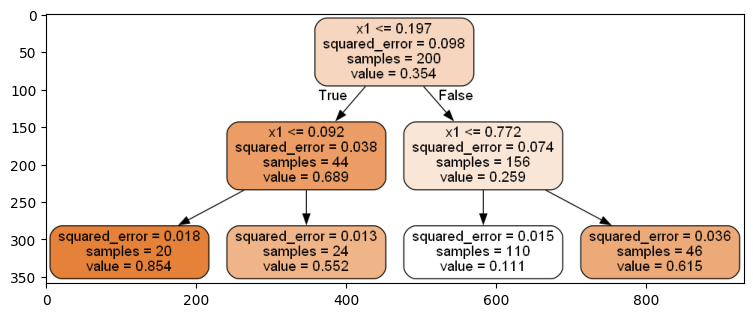

In [18]:
plt.figure(figsize=(9,9))
img = mpimg.imread('regression_tree.png')
imgplot = plt.imshow(img)
plt.show()

- It predicts a values iso a class in each node. 
- For example, suppose you want to make a prediction for a new instance with x = 0.6. 
- You traverse the tree starting at the root, and you eventually reach the leaf node that predicts value=0.111. 
- This prediction is the average target value of the 110 training instances associated with this leaf node, and it
results in a mean squared error equal to 0.015 over these 110 instances.

- This model’s predictions are represented on the left in the figure below. 
- If you set max_depth=3, you get the predictions represented on the right. 
- Notice how the predicted value for each region is always the average target value of the instances in that region. 
- The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

![](img/tree_regression_plot.png)

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that **minimizes the MSE**.

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks:

- Without any regularization (i.e., using the default hyperparameters), you get the predictions on the left. These predictions are obviously overfitting the training set very badly. 
- Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right:
![](img/tree_regression_regularization_plot.png)

## Exercises
1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?
1. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?
1. If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?
1. Check the gini impurity in the orange and green node in the first decision tree above. 